In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_score,
                             recall_score, f1_score,fbeta_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,roc_curve, confusion_matrix,brier_score_loss
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import plotly.express as px
from datetime import date, timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
sns.set_style("whitegrid")
sns.set(font_scale=2)

C:\Users\Julia\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Part 1 - Exploratory Data Analysis

In [3]:
df = pd.read_json('logins.json')

In [4]:
df

login_time
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
2     1970-01-01 20:16:37
3     1970-01-01 20:16:36
4     1970-01-01 20:26:21
...                   ...
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

[93142 rows x 1 columns]

In [5]:
sorted_df = df.sort_values(by='login_time').reset_index(drop=True)

In [6]:
sorted_df['login_time'] = pd.to_datetime(sorted_df['login_time'])

In [7]:
summary = sorted_df.resample('15T', on='login_time').count()

In [8]:
summary['date'] = [d.date() for d in summary.index]
summary['time'] = [d.time() for d in summary.index]

In [9]:
summary['day_of_week'] = pd.to_datetime(summary['date']).dt.day_name()

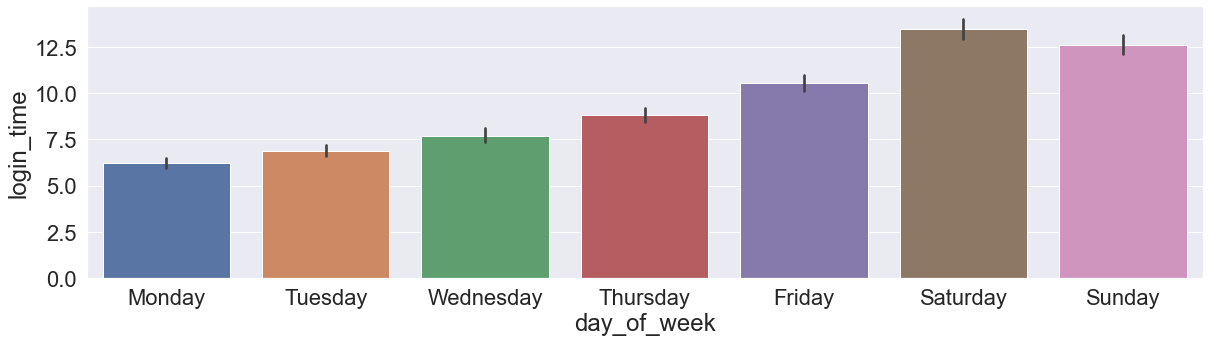

In [10]:
plt.rcParams["figure.figsize"] = (20,5)
sns.barplot(x='day_of_week',y='login_time',data=summary,order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);

In [11]:
summary['time'] = summary.time.map(lambda x: str(x))
summary['hour'] = summary.time.map(lambda x: int(x[:2]))

In [12]:
b = [0,4,8,12,16,20,24]
l = ['Night', 'Early Morning','Morning','Noon','Evening','Late Evening']
summary['time_of_day'] = pd.cut(summary['hour'], bins=b, labels=l, include_lowest=True)

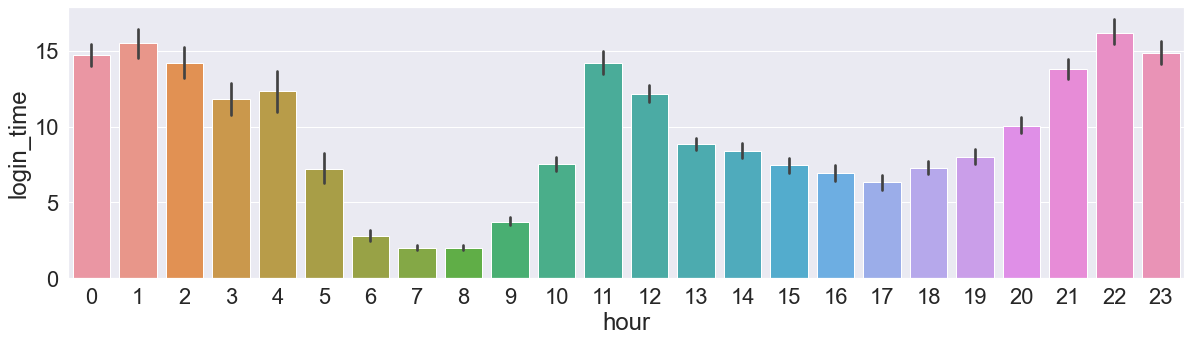

In [13]:
sns.barplot(x='hour',y='login_time',data=summary);

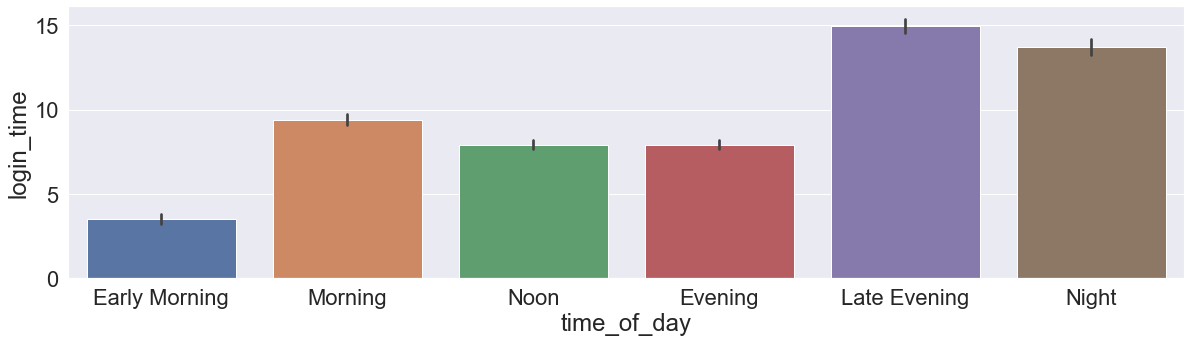

In [14]:
sns.barplot(x='time_of_day',y='login_time',data=summary,order=['Early Morning','Morning','Noon','Evening','Late Evening','Night'],);

## Most logins occur Friday, Saturday and Sunday.
## Most logins occur in the Morning, Late Evening and Night

# Part 2 - Experiment and metrics design

## 1. A key measure of success for driver partners would be profitability increase due to:
## - The reimbursement of all toll costs. 
## - Even though Gotham and Metropolis have different circadian rhythms, it doesn't mean that this applies to every resident and there may still be demand for services outside the most active period of time. This demand would allow driver partners to increase the cost of their services. An increase in customer satisfaction due to shorter wait periods and thus an increase in tips could also occur.

## 2. 
## * To experiment, I would split drivers into two groups: the first group would still have to pay tolls. The second group would have the toll cost reimbursed to encourage them to serve both cities regardless of the activity periods. Next, I would track changes in revenue of driver partners over a significant period of time (preferably a year to account for seasonal changes). Next, I would compare two groups to see if revenue in the second group changes in any way compared to the first group. 
## * I would calculate the average revenue for both groups over a given period of time. I would have performed a T-test where the null hypothesis would state that there is no difference between the two groups.
## * If I rejected the null hypothesis, I would inform the Ultimate managers that the toll reimbursement strategy was effective. However even distribution of drivers in both cities can increase profitability, it can decrease customer satisfaction in the city with higher demand due to decreased number of available drivers and an increased waiting period.

# Part 3 - Predictive modeling

In [15]:
data = pd.read_json('ultimate_data_challenge.json')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
last_date= pd.to_datetime(data.last_trip_date.max())
thirty_days_ago = last_date - timedelta(days=30)

In [18]:
thirty_days_ago

Timestamp('2014-06-01 00:00:00')

In [19]:
data['active_user']  = np.where(data['last_trip_date'] >= '2014-06-01', 1, 0)

In [20]:
data.active_user.value_counts(normalize=True)*100

0    62.392
1    37.608
Name: active_user, dtype: float64

## Column 'active_user' has two classes:
## 1 - a user was active in the last 30 days
## 0 - a user wasn't active in the last 30 days
## This column will be our target variable.

In [21]:
data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  active_user  
0         46.2      3.67                   5.0            1  
1         50.0      8.26                   5.0            0  
2        100.0      0.77                   5.0            0  
3         80.0      2.36                   4.9            1  
4         82.4      3.13                   4.9            0

## Missing values
## Columns 'avg_rating_of_driver', 'phone' and 'avg_rating_by_driver' have missing values.

In [22]:
data.isna().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
active_user               False
dtype: bool

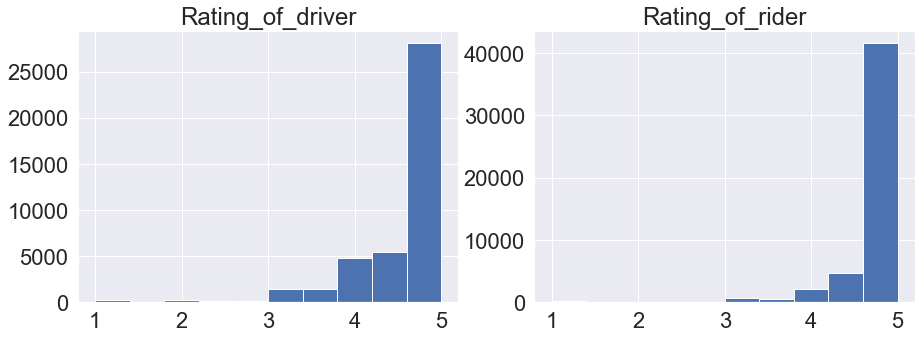

In [23]:
plt.rcParams["figure.figsize"] = (15,5)
fig, axes = plt.subplots(1, 2)
data.avg_rating_of_driver.hist(bins=10,ax=axes[0], alpha=1, label='Rating_of_driver')
data.avg_rating_by_driver.hist(bins=10,ax=axes[1], alpha=1, label='Rating_of_rider')
axes[0].set_title('Rating_of_driver')
axes[1].set_title('Rating_of_rider');

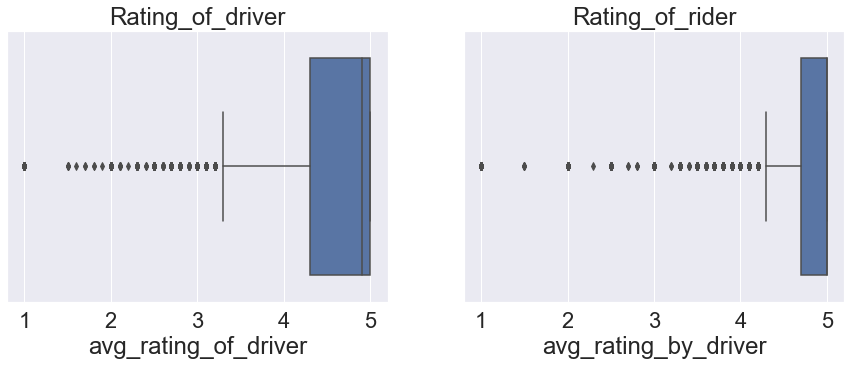

In [24]:
fig, axes = plt.subplots(1, 2)
sns.boxplot(x=data.avg_rating_of_driver,ax=axes[0])
sns.boxplot(x=data.avg_rating_by_driver,ax=axes[1])
axes[0].set_title('Rating_of_driver')
axes[1].set_title('Rating_of_rider');

## Since the distribution of these two numeric variables is skewed, we can use a median value to impute missing values.

In [25]:
data['avg_rating_of_driver'] = data['avg_rating_of_driver'].fillna(data['avg_rating_of_driver'].median())

In [26]:
data['avg_rating_by_driver'] = data['avg_rating_by_driver'].fillna(data['avg_rating_by_driver'].median())

## Missing values in categorical variable 'phone' will be replaced with the 'unknown' category.

In [27]:
data['phone'] = data['phone'].fillna('unknown')

In [28]:
data.phone.value_counts()

iPhone     34582
Android    15022
unknown      396
Name: phone, dtype: int64

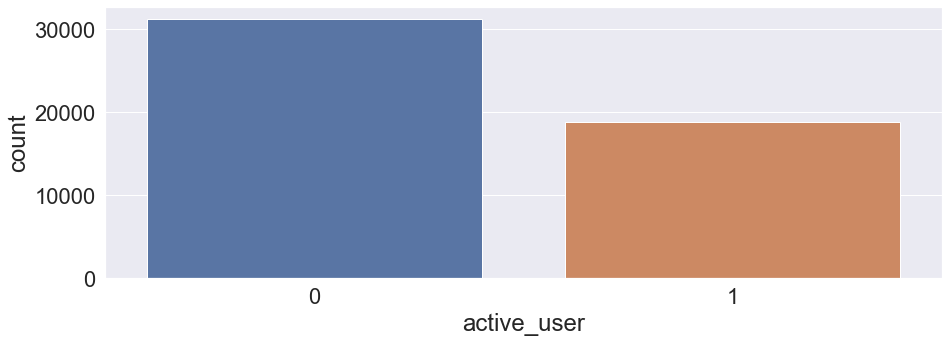

In [29]:
sns.countplot(x= data.active_user);

## We need to convert columns with dates to datetime category and create a new feature showing how many days an account was active from the signup date

In [30]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

In [31]:
data['account active (days)'] = data['last_trip_date'] - data['signup_date']
data['account active (days)'] = data['account active (days)']/np.timedelta64(1,'D')

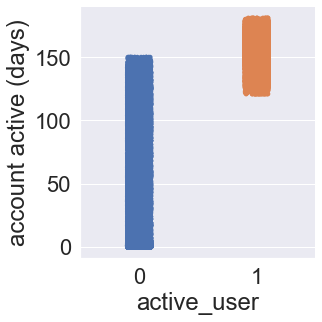

In [32]:
sns.catplot(x='active_user',y='account active (days)', data=data);

## Now that we used columns with dates to create new features, these columns can be removed.

In [33]:
data = data.drop(columns=['signup_date','last_trip_date'])

## Exploring numeric variables

In [34]:
corr = data.corr()
fig = px.imshow(corr,width=1000, height=1000)
fig.show()

## Predictor variables 'avg_surge' and 'surge_pct' have high correlation, however it's not higher than 0.95, therefore we can keep both variables for the time being.

In [35]:
df = data._get_numeric_data()

In [36]:
df.ultimate_black_user.replace({False: 0, True: 1},inplace=True)

In [37]:
X = df.drop(columns='active_user',axis=1)
y = df[['active_user']]

In [38]:
X

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                           4                   4.7       1.10       15.4   
1                           0                   5.0       1.00        0.0   
2                           3                   4.3       1.00        0.0   
3                           9                   4.6       1.14       20.0   
4                          14                   4.4       1.19       11.8   
...                       ...                   ...        ...        ...   
49995                       0                   5.0       1.00        0.0   
49996                       1                   4.9       1.00        0.0   
49997                       0                   5.0       1.00        0.0   
49998                       2                   3.0       1.00        0.0   
49999                       0                   4.9       1.00        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  \
0                        1         46.2      3.67                   5.0   
1                        0         50.0      8.26                   5.0   
2                        0        100.0      0.77                   5.0   
3                        1         80.0      2.36                   4.9   
4                        0         82.4      3.13                   4.9   
...                    ...          ...       ...                   ...   
49995                    0        100.0      5.63                   4.2   
49996                    0          0.0      0.00                   4.0   
49997                    1        100.0      3.86                   5.0   
49998                    0        100.0      4.58                   3.5   
49999                    0          0.0      3.49                   5.0   

       account active (days)  
0                      143.0  
1                       96.0  
2                        1.0  
3                      170.0  
4                       47.0  
...                      ...  
49995                  131.0  
49996                    1.0  
49997                  111.0  
49998                    1.0  
49999                   92.0  

[50000 rows x 9 columns]

In [39]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor                features
0    1.434328  trips_in_first_30_days
1   51.674028    avg_rating_of_driver
2   49.095580               avg_surge
3    2.822659               surge_pct
4    1.688549     ultimate_black_user
5    3.802319             weekday_pct
6    2.149509                avg_dist
7   67.147323    avg_rating_by_driver
8    3.371518   account active (days)

In [40]:
X = X.drop(columns=['avg_rating_by_driver','avg_surge'])

In [41]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

VIF Factor                features
0    1.430798  trips_in_first_30_days
1    7.105776    avg_rating_of_driver
2    1.234481               surge_pct
3    1.682702     ultimate_black_user
4    3.709582             weekday_pct
5    2.122602                avg_dist
6    3.300277   account active (days)

## Variance inflation factor below 10 is acceptable, therefore we can keep the rest of the columns

## Exploring categorical variables

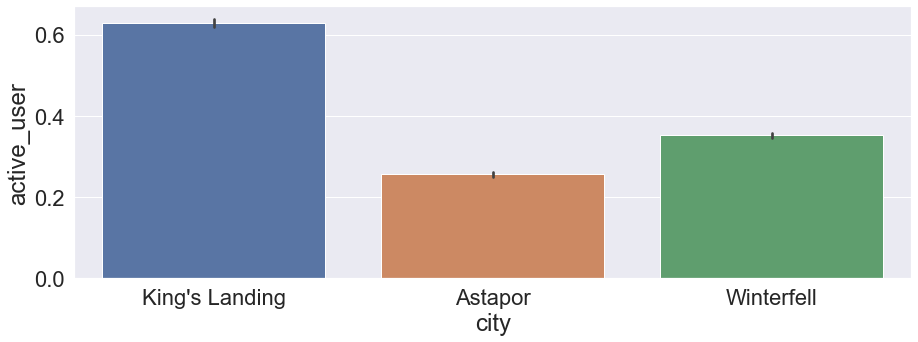

In [42]:
sns.barplot(x='city',y='active_user',data=data);

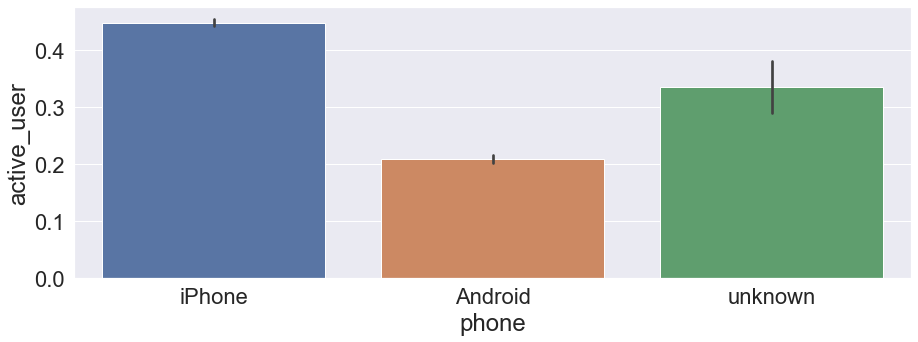

In [43]:
sns.barplot(x='phone',y='active_user',data=data);

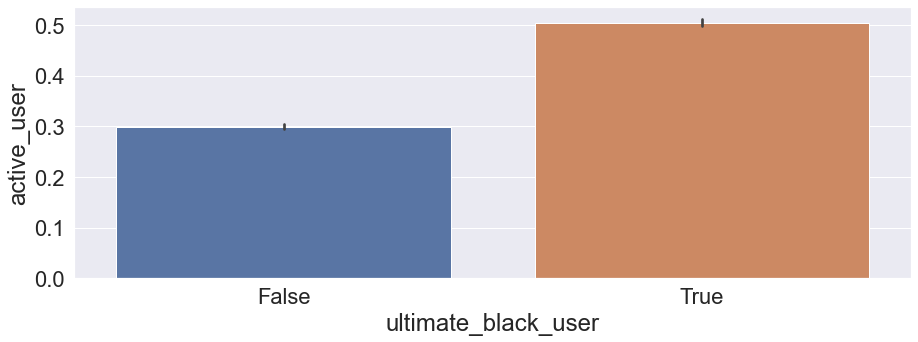

In [44]:
sns.barplot(x='ultimate_black_user',y='active_user',data=data);

## Modeling

## Neither logistic regression nor random forest classifier are sensitive to skewness in the data. Neither they need scaling.

In [45]:
## 'account active (days)' leads to overfitting?
y = data[['active_user']]
X = data.drop(['active_user','avg_rating_by_driver','avg_surge','account active (days)'],axis=1)

In [46]:
X.ultimate_black_user.replace({False: 0, True: 1},inplace=True)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [48]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [49]:
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000, 10), (15000, 10), (35000,), (15000,))

In [50]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=42)

## Logistic regression

In [51]:
lr_parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'C':[100, 10, 1.0, 0.1, 0.01],
             'penalty':['none', 'l1', 'l2', 'elasticnet']}

## We will use RandomizedSearchCV to speed up the process

In [52]:
lr_model = LogisticRegression()
lr_clf = RandomizedSearchCV(lr_model, param_distributions= lr_parameters,cv=cv,scoring='roc_auc')

In [53]:
lr_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(),
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='roc_auc')

In [54]:
print('The best score is', lr_clf.best_score_,'with following best parameters',lr_clf.best_params_)

The best score is 0.7607159878812142 with following best parameters {'solver': 'sag', 'penalty': 'l2', 'C': 100}


In [55]:
lr_model = LogisticRegression(C=0.1, penalty='l2', 
                              solver='newton-cg',random_state=50).fit(X_train,y_train)
lr_probs = lr_model.predict_proba(X_test)[:, 1]
y_pred = lr_model.predict(X_test)

In [56]:
print(f'Logistic Regression\n')
roc = roc_auc_score(y_test, lr_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, y_pred,zero_division=0))

Logistic Regression

ROC AUC: 0.7607
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      9379
           1       0.66      0.50      0.57      5621

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



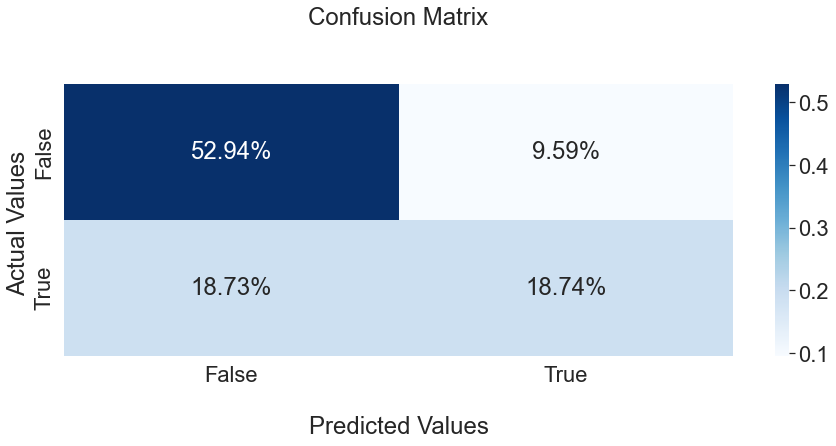

In [57]:
cf_matrix = confusion_matrix(y_test,y_pred)
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

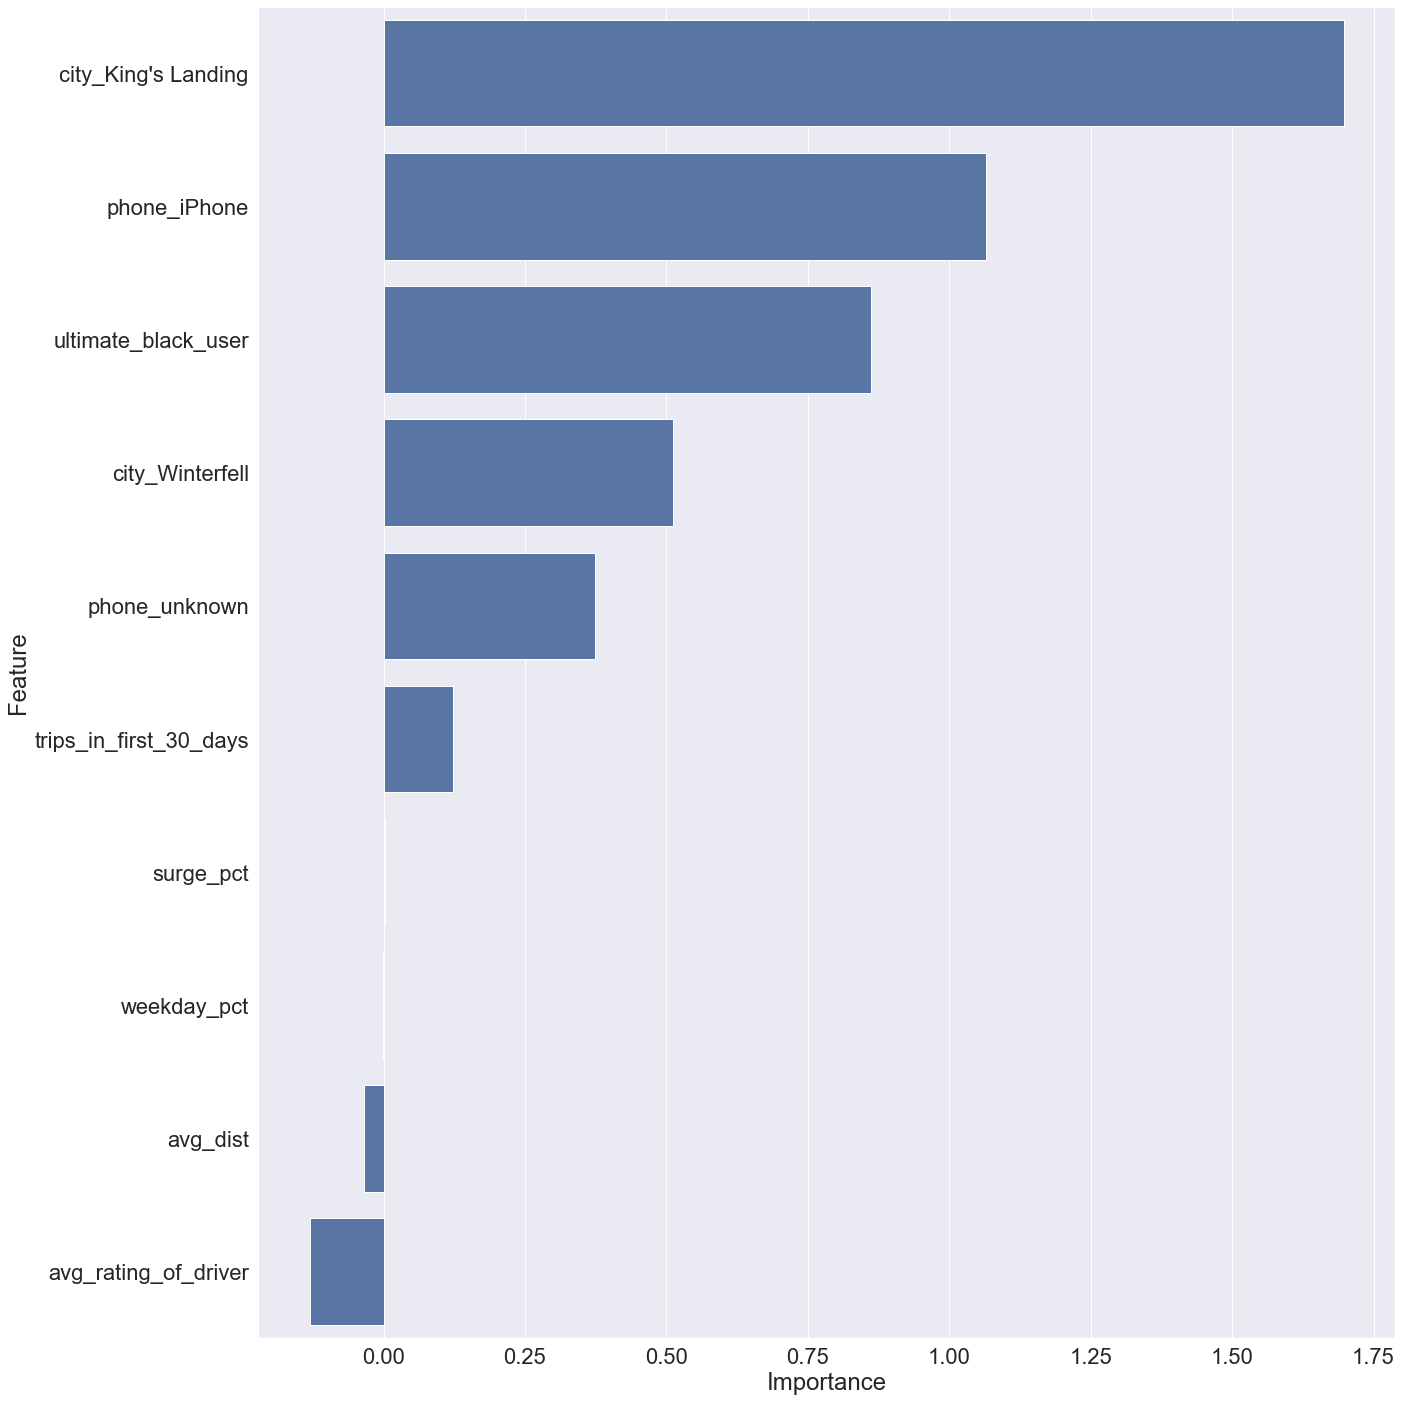

In [58]:
lrfeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': lr_model.coef_.ravel()}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = lrfeatureimportance, color = 'b')
plt.tight_layout()

## Random Forest Classifier

In [59]:
parameters_rf = {'n_estimators' : [10, 100, 200, 500, 1000], 
                'max_features' : ['auto','sqrt', 'log2'],
                'criterion':['gini', 'entropy', 'log_loss'],
                'max_depth': [10, 20, 30, 40, 50]}

In [60]:
rf_model = RandomForestClassifier()
rf_clf = RandomizedSearchCV(rf_model, param_distributions = parameters_rf,cv=cv,scoring='roc_auc')

In [61]:
rf_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000]},
                   scoring='roc_auc')

In [62]:
print('The best score is', rf_clf.best_score_,'with following best parameters',rf_clf.best_params_)

The best score is 0.8473820650874423 with following best parameters {'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


In [63]:
rf_model = RandomForestClassifier(criterion='gini',max_depth=10,
                                  max_features='auto',n_estimators=200,
                                  random_state=50)
rf_model.fit(X_train, y_train)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_preds = rf_model.predict(X_test)

In [64]:
print(f'Random Forest Classifier\n')
roc = roc_auc_score(y_test, rf_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, rf_preds,zero_division=0))

Random Forest Classifier

ROC AUC: 0.8408
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9379
           1       0.73      0.64      0.68      5621

    accuracy                           0.78     15000
   macro avg       0.76      0.75      0.75     15000
weighted avg       0.77      0.78      0.77     15000



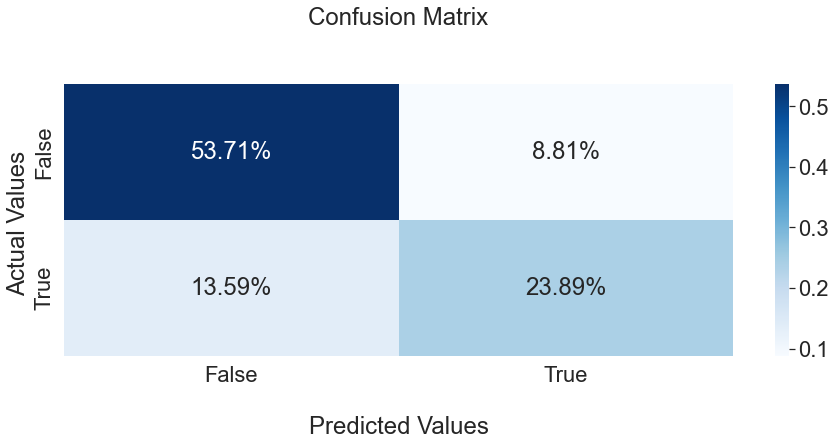

In [65]:
cf_matrix = confusion_matrix(y_test,rf_preds)
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

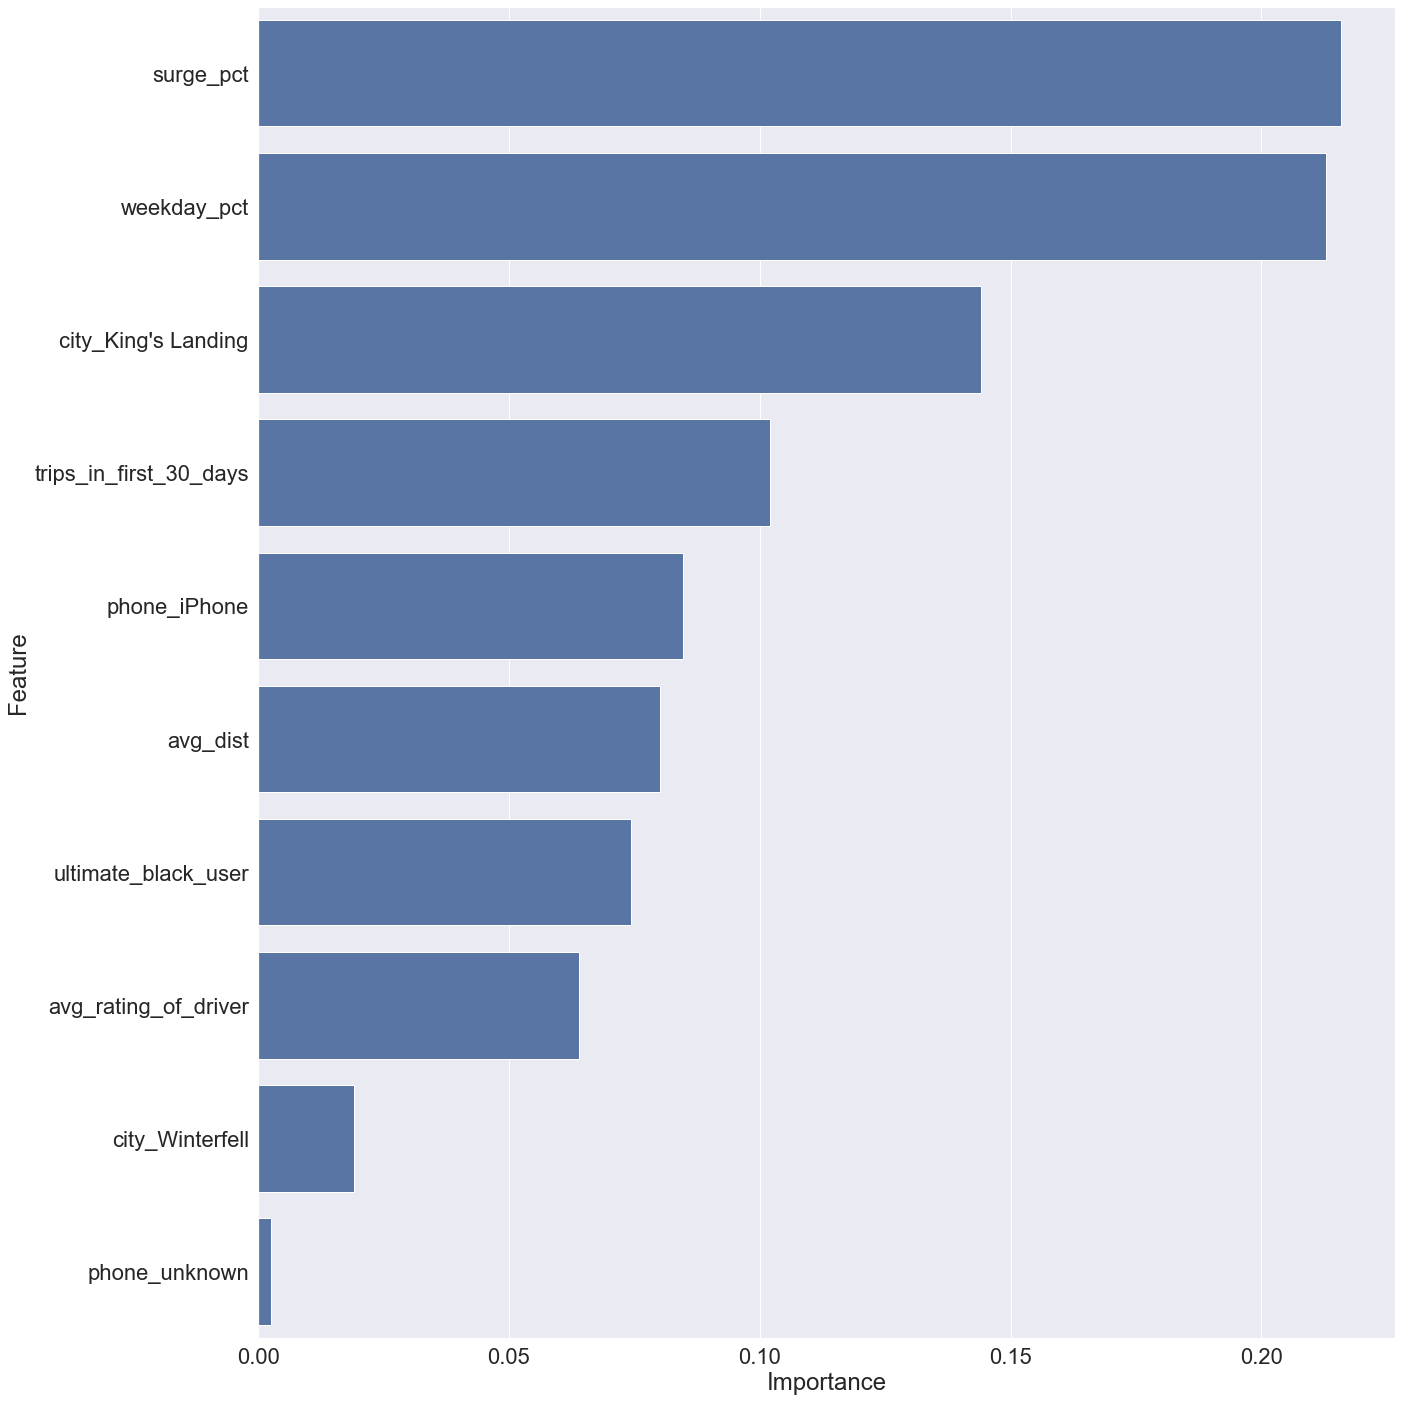

In [66]:
rffeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = rffeatureimportance, color = 'b')
plt.tight_layout()

## XGBoost Classifier

In [67]:
xgb_parameters = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
               'max_depth' : [1,3,4,8,16],
               'min_child_weight' : [1,4,5,8,10],
               'colsample_bytree' : [0.6,0.8],
               'subsample' : [0.6,0.8,1.0],
               'n_estimators' : [200,400,800,1600,6400],
               'reg_alpha' : np.arange(0.001, 10, 1) }

In [68]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_clf = RandomizedSearchCV(xgb_model, param_distributions = xgb_parameters,cv=cv,scoring='roc_auc')

In [69]:
xgb_clf.fit(X_train,y_train)

[18:27:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:28:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:30:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None...
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3],
                                        'max_depth': [1, 3, 4, 8, 16],
                                        'min_child_weight': [1, 4, 5, 8, 10],
                                        'n_estimators': [200, 400, 800, 1600,
                                                         6400],
                                        'reg_alpha': array([1.000e-03, 1.001e+00, 2.001e+00, 3.001e+00, 4.001e+00, 5.001e+00,
       6.001e+00, 7.001e+00, 8.001e+00, 9.001e+00]),
                                        'subsample': [0.6, 0.8, 1.0]},
                   scoring='roc_auc')

In [70]:
print('The best score is', xgb_clf.best_score_,'with following best parameters',xgb_clf.best_params_)

The best score is 0.8556856208559813 with following best parameters {'subsample': 0.6, 'reg_alpha': 9.000999999999998, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [78]:
xgb_model = xgb.XGBClassifier(subsample=0.6, reg_alpha=9.001, 
                              n_estimators=400, min_child_weight=4, 
                              max_depth = 4, learning_rate = 0.1, colsample_bytree = 0.6,
                            seed=42, verbosity=0)

In [79]:
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=9.001, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=0)

In [80]:
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
xgb_preds = xgb_model.predict(X_test)

In [81]:
print(f'XGBoost Classifier\n')
roc = roc_auc_score(y_test, xgb_probs)
print(f'ROC AUC: {round(roc, 4)}')
print(classification_report(y_test, xgb_preds,zero_division=0))

XGBoost Classifier

ROC AUC: 0.8493
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9379
           1       0.74      0.67      0.70      5621

    accuracy                           0.79     15000
   macro avg       0.77      0.76      0.77     15000
weighted avg       0.78      0.79      0.78     15000



In [82]:
cf_matrix = confusion_matrix(y_test,xgb_preds)

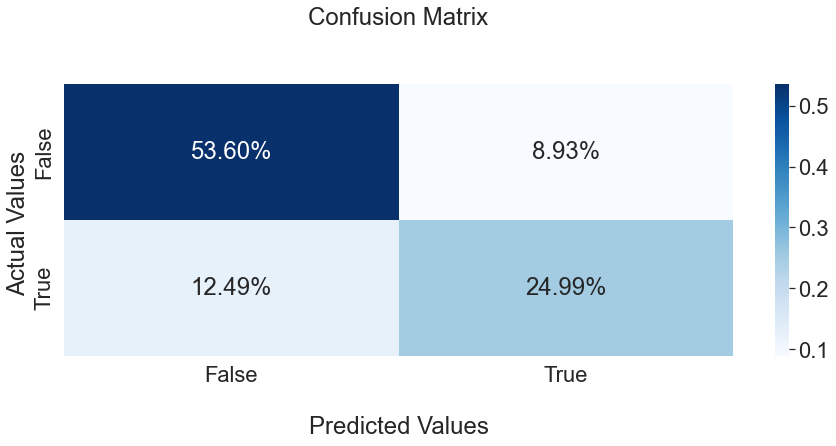

In [83]:
ax =sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

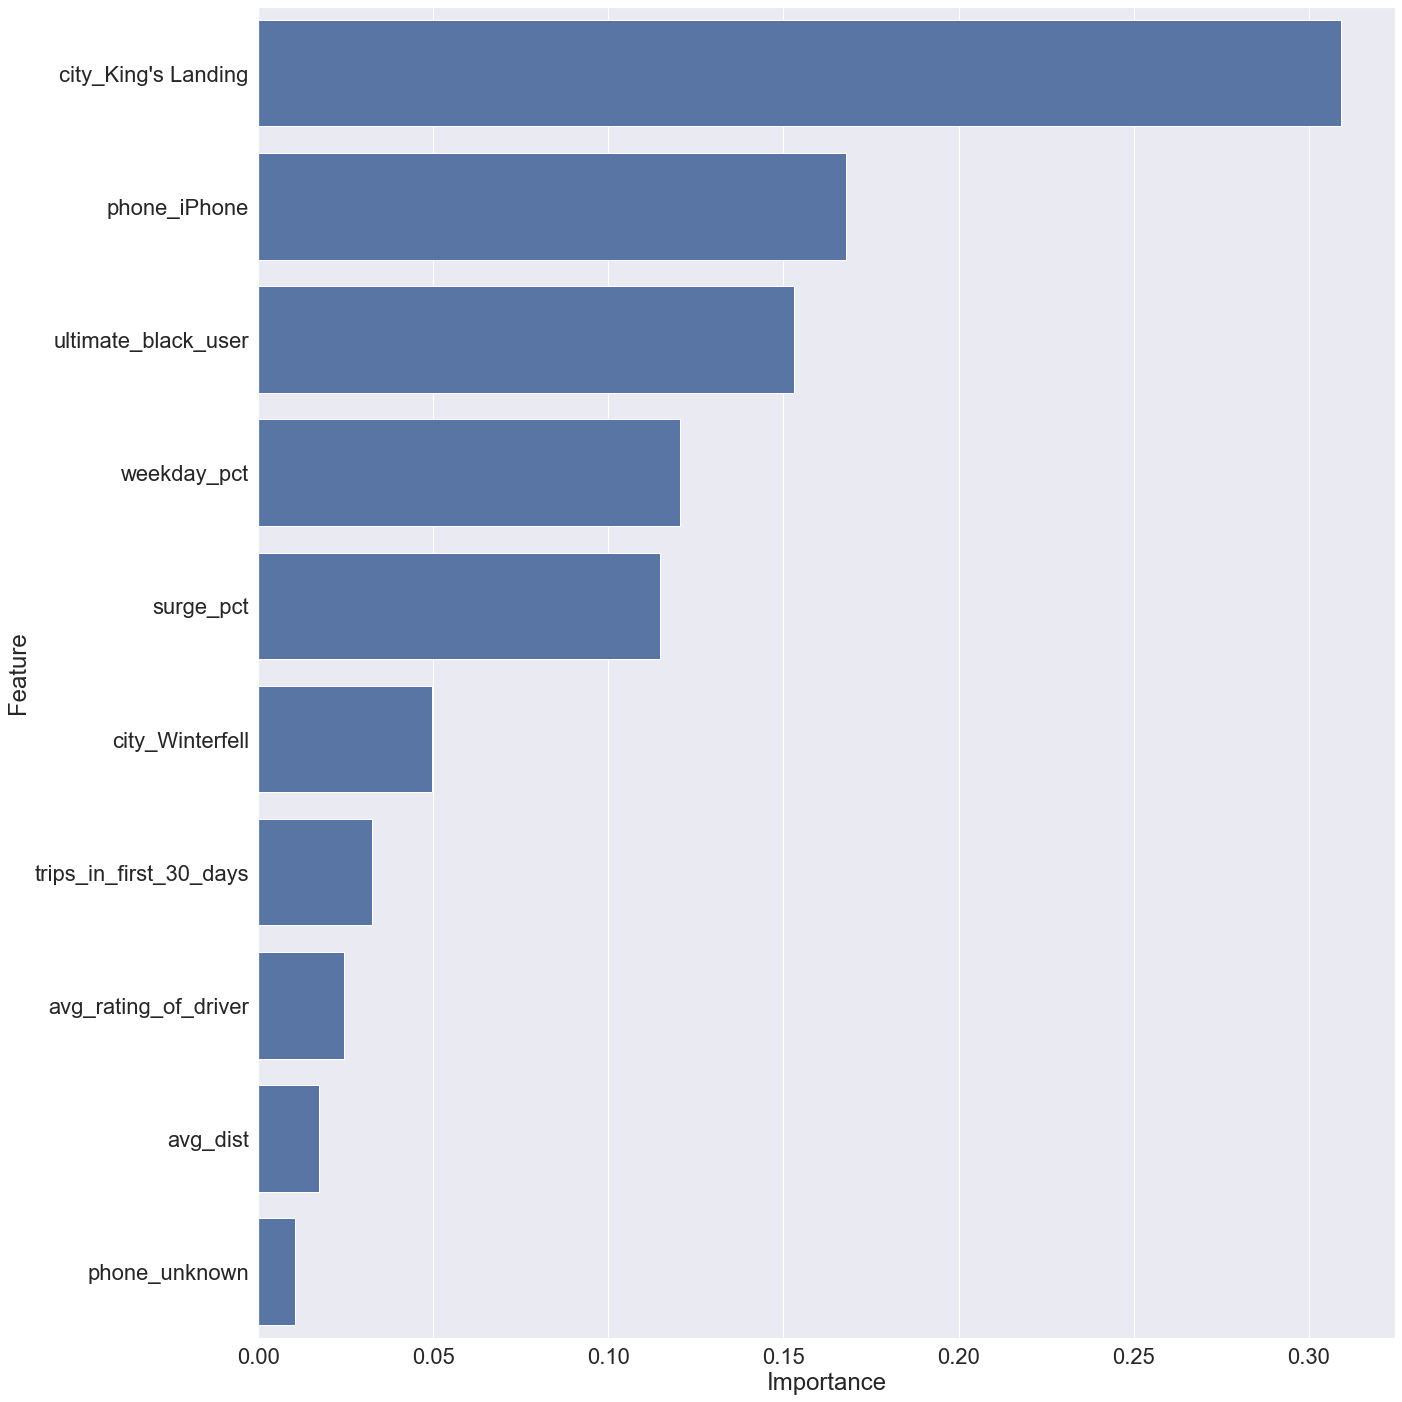

In [85]:
xgbfeatureimportance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_}).sort_values('Importance', ascending = False)
plt.figure(figsize = (20,20))
ax = sns.barplot(x = 'Importance', y = 'Feature', data = xgbfeatureimportance, color = 'b')
plt.tight_layout()

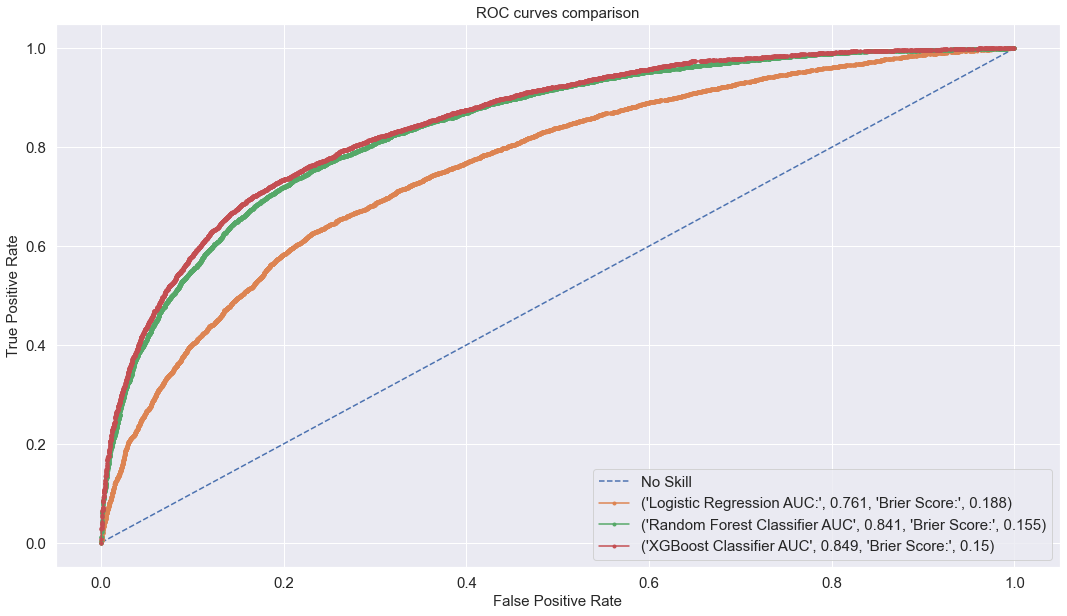

In [84]:
fig = plt.gcf()
fig.set_size_inches(18, 10, forward=True)
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = lr_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_br = brier_score_loss(y_test, lr_probs,pos_label=1)
rf_br = brier_score_loss(y_test, rf_probs,pos_label=1)
xgb_br = brier_score_loss(y_test, xgb_probs,pos_label=1)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.',label=('Logistic Regression AUC:',round(lr_auc,3),'Brier Score:',round(lr_br,3)))
plt.plot(rf_fpr, rf_tpr, marker='.',label=('Random Forest Classifier AUC',round(rf_auc,3),'Brier Score:',round(rf_br,3)))
plt.plot(xgb_fpr, xgb_tpr, marker='.',label=('XGBoost Classifier AUC',round(xgb_auc,3),'Brier Score:',round(xgb_br,3)))
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('ROC curves comparison',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show();

# Answers:
# 1. 37.6 % of users were retained.
# 2. The most robust model out of the three is the XGBoost Classifier with an AUC score of 0.849. The model makes better predictions for users who were not active with higher recall and precision compared to active users.
# 3. The most important features are 'city' and 'phone' and 'ultimate black users'. Ultimate could use this information to provide better availability of drivers in different cities, improve the user experience for Android users, and add more upgrades similar to 'Ultimate Black' that increase passenger comfort. 